# Chapter 14: Part-of-Speech and Sequence Annotation
## Part-of-Speech Tagging with Feed-Forward Networks 

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Modules

We import modules and a CoNLL reader.

In [1]:
import numpy as np

In [2]:
import torch
from torch import nn

In [3]:
from sklearn.feature_extraction import DictVectorizer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import ud_datasets
from conll_dictorizer import CoNLLDictorizer

from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
EPOCHS = 16
LR = 0.005
LOWERCASE = True

In [5]:
torch.manual_seed(4321)

## Loading the corpus

We load a corpus from Universal Dependencies: https://universaldependencies.org/ hosted by GitHub

In [6]:
CORPUS = 'EWT'

In [7]:
if CORPUS == 'EWT':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_en_ewt()
elif CORPUS == 'Talbanken':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_sv_talbanken()
elif CORPUS == 'GSD':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_fr_gsd()

In [8]:
column_names

['ID',
 'FORM',
 'LEMMA',
 'UPOS',
 'XPOS',
 'FEATS',
 'HEAD',
 'DEPREL',
 'HEAD',
 'DEPS',
 'MISC']

In [9]:
train_sentences[:500]

'# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000\n# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001\n# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001\n# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.\n1\tAl\tAl\tPROPN\tNNP\tNumber=Sing\t0\troot\t0:root\tSpaceAfter=No\n2\t-\t-\tPUNCT\tHYPH\t_\t3\tpunct\t3:punct\tSpaceAfter=No\n3\tZaman\tZam'

## Dictorizing the corpus

We store the corpus word in a dictionary, where the keys are the CoNLL-U columns

In [10]:
conll_dict = CoNLLDictorizer(column_names)

In [11]:
train_dict = conll_dict.transform(train_sentences)
val_dict = conll_dict.transform(val_sentences)
test_dict = conll_dict.transform(test_sentences)

In [12]:
train_dict[0][:10]

[{'ID': '1',
  'FORM': 'Al',
  'LEMMA': 'Al',
  'UPOS': 'PROPN',
  'XPOS': 'NNP',
  'FEATS': 'Number=Sing',
  'HEAD': '0:root',
  'DEPREL': 'root',
  'DEPS': 'SpaceAfter=No'},
 {'ID': '2',
  'FORM': '-',
  'LEMMA': '-',
  'UPOS': 'PUNCT',
  'XPOS': 'HYPH',
  'FEATS': '_',
  'HEAD': '3:punct',
  'DEPREL': 'punct',
  'DEPS': 'SpaceAfter=No'},
 {'ID': '3',
  'FORM': 'Zaman',
  'LEMMA': 'Zaman',
  'UPOS': 'PROPN',
  'XPOS': 'NNP',
  'FEATS': 'Number=Sing',
  'HEAD': '1:flat',
  'DEPREL': 'flat',
  'DEPS': '_'},
 {'ID': '4',
  'FORM': ':',
  'LEMMA': ':',
  'UPOS': 'PUNCT',
  'XPOS': ':',
  'FEATS': '_',
  'HEAD': '7:punct',
  'DEPREL': 'punct',
  'DEPS': '_'},
 {'ID': '5',
  'FORM': 'American',
  'LEMMA': 'American',
  'UPOS': 'ADJ',
  'XPOS': 'JJ',
  'FEATS': 'Degree=Pos',
  'HEAD': '6:amod',
  'DEPREL': 'amod',
  'DEPS': '_'},
 {'ID': '6',
  'FORM': 'forces',
  'LEMMA': 'force',
  'UPOS': 'NOUN',
  'XPOS': 'NNS',
  'FEATS': 'Number=Plur',
  'HEAD': '7:nsubj',
  'DEPREL': 'nsubj',
  'DEPS

## Feature extraction

We extract the features and we store them in a dictionary. This $y$ output is extracted from the `UPOS` column for the Universal dependencies.

In [13]:
def extract_cols(sent_dict, x='FORM', y='UPOS'):
    (input, target) = ([], [])
    for word in sent_dict:
        input += [word[x]]
        target += [word.get(y, None)]
    return input, target

In [14]:
train_cols = [extract_cols(sent_dict)
              for sent_dict in train_dict]
val_cols = [extract_cols(sent_dict)
            for sent_dict in val_dict]
test_cols = [extract_cols(sent_dict)
             for sent_dict in test_dict]

In [15]:
train_sent_words, train_sent_pos = zip(*train_cols)
val_sent_words, val_sent_pos = zip(*val_cols)
test_sent_words, test_sent_pos = zip(*test_cols)

We set the words in lowercase

In [16]:
if LOWERCASE:
    train_sent_words = [list(map(str.lower, sent_words))
                        for sent_words in train_sent_words]
    val_sent_words = [list(map(str.lower, sent_words))
                      for sent_words in val_sent_words]
    test_sent_words = [list(map(str.lower, sent_words))
                       for sent_words in test_sent_words]

In [17]:
train_sent_words[8131]

['or', 'you', 'can', 'visit', 'temples', 'or', 'shrines', 'in', 'okinawa', '.']

In [18]:
train_sent_pos[8131]

['CCONJ',
 'PRON',
 'AUX',
 'VERB',
 'NOUN',
 'CCONJ',
 'NOUN',
 'ADP',
 'PROPN',
 'PUNCT']

## The `X` Matrix

In [19]:
def create_X_cat(sentence: list[str],
                 w_size: int = 2) -> list[dict[int: str]]:
    start_pads = ['__BOS__'] * w_size
    end_pads = ['__EOS__'] * w_size
    sentence = start_pads + sentence + end_pads
    # We extract the features
    X = []
    for i in range(len(sentence) - 2 * w_size):
        x = []
        for j in range(2 * w_size + 1):
            x += [sentence[i + j]]
        X += [x]
    X = [dict(enumerate(x)) for x in X]
    return X

In [20]:
train_sent_words[0]

['al',
 '-',
 'zaman',
 ':',
 'american',
 'forces',
 'killed',
 'shaikh',
 'abdullah',
 'al',
 '-',
 'ani',
 ',',
 'the',
 'preacher',
 'at',
 'the',
 'mosque',
 'in',
 'the',
 'town',
 'of',
 'qaim',
 ',',
 'near',
 'the',
 'syrian',
 'border',
 '.']

In [21]:
create_X_cat(train_sent_words[8131])

[{0: '__BOS__', 1: '__BOS__', 2: 'or', 3: 'you', 4: 'can'},
 {0: '__BOS__', 1: 'or', 2: 'you', 3: 'can', 4: 'visit'},
 {0: 'or', 1: 'you', 2: 'can', 3: 'visit', 4: 'temples'},
 {0: 'you', 1: 'can', 2: 'visit', 3: 'temples', 4: 'or'},
 {0: 'can', 1: 'visit', 2: 'temples', 3: 'or', 4: 'shrines'},
 {0: 'visit', 1: 'temples', 2: 'or', 3: 'shrines', 4: 'in'},
 {0: 'temples', 1: 'or', 2: 'shrines', 3: 'in', 4: 'okinawa'},
 {0: 'or', 1: 'shrines', 2: 'in', 3: 'okinawa', 4: '.'},
 {0: 'shrines', 1: 'in', 2: 'okinawa', 3: '.', 4: '__EOS__'},
 {0: 'in', 1: 'okinawa', 2: '.', 3: '__EOS__', 4: '__EOS__'}]

In [22]:
train_sent_pos[8131]

['CCONJ',
 'PRON',
 'AUX',
 'VERB',
 'NOUN',
 'CCONJ',
 'NOUN',
 'ADP',
 'PROPN',
 'PUNCT']

In [23]:
X_train_cat = [row for sent in train_sent_words
               for row in create_X_cat(sent)]
X_val_cat = [row for sent in val_sent_words
             for row in create_X_cat(sent)]
X_test_cat = [row for sent in test_sent_words
              for row in create_X_cat(sent)]

In [24]:
y_train_cat = [pos for sent in train_sent_pos
               for pos in sent]
y_val_cat = [pos for sent in val_sent_pos
             for pos in sent]
y_test_cat = [pos for sent in test_sent_pos
              for pos in sent]

In [25]:
len(y_train_cat)

207229

In [26]:
X_train_cat[:10]

[{0: '__BOS__', 1: '__BOS__', 2: 'al', 3: '-', 4: 'zaman'},
 {0: '__BOS__', 1: 'al', 2: '-', 3: 'zaman', 4: ':'},
 {0: 'al', 1: '-', 2: 'zaman', 3: ':', 4: 'american'},
 {0: '-', 1: 'zaman', 2: ':', 3: 'american', 4: 'forces'},
 {0: 'zaman', 1: ':', 2: 'american', 3: 'forces', 4: 'killed'},
 {0: ':', 1: 'american', 2: 'forces', 3: 'killed', 4: 'shaikh'},
 {0: 'american', 1: 'forces', 2: 'killed', 3: 'shaikh', 4: 'abdullah'},
 {0: 'forces', 1: 'killed', 2: 'shaikh', 3: 'abdullah', 4: 'al'},
 {0: 'killed', 1: 'shaikh', 2: 'abdullah', 3: 'al', 4: '-'},
 {0: 'shaikh', 1: 'abdullah', 2: 'al', 3: '-', 4: 'ani'}]

## Vectorizing the Matrix

In [27]:
dict_vectorizer = DictVectorizer(sparse=False, dtype=np.float32)

In [28]:
X_train = dict_vectorizer.fit_transform(X_train_cat)
X_val = dict_vectorizer.transform(X_val_cat)
X_test = dict_vectorizer.transform(X_test_cat)

## Training the model

In [29]:
y_train_cat[:10]

['PROPN',
 'PUNCT',
 'PROPN',
 'PUNCT',
 'ADJ',
 'NOUN',
 'VERB',
 'PROPN',
 'PROPN',
 'PROPN']

In [30]:
idx2pos = dict(enumerate(sorted(set(y_train_cat))))

In [31]:
pos2idx = {v: k for k, v in idx2pos.items()}

In [32]:
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)

In [33]:
y_train = torch.LongTensor(
    list(map(lambda x: pos2idx.get(x), y_train_cat)))
y_val = torch.LongTensor(
    list(map(lambda x: pos2idx.get(x), y_val_cat)))
y_test = torch.LongTensor(
    list(map(lambda x: pos2idx.get(x), y_test_cat)))

In [34]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=512, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=2048, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=2048, shuffle=False)

In [35]:
SIMPLE = True

In [36]:
if SIMPLE:
    model = nn.Sequential(
        nn.Linear(X_train.size(dim=1), len(pos2idx))
    )
else:
    model = nn.Sequential(
        nn.Linear(X_train.size(dim=1), 2 * len(pos2idx)),
        nn.ReLU(),
        nn.Linear(2 * len(pos2idx), len(pos2idx)),
    )

In [37]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.NAdam(model.parameters(), lr=LR)

In [38]:
def evaluate(model,
             loss_fn,
             dataloader) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        loss = 0
        acc = 0
        batch_cnt = 0
        for X_batch, y_batch in dataloader:
            batch_cnt += 1
            y_batch_pred = model(X_batch)
            loss += loss_fn(y_batch_pred, y_batch).item()
            acc += (sum(torch.argmax(y_batch_pred, dim=-1)
                    == y_batch)/y_batch.size(dim=0)).item()
        return loss/batch_cnt, acc/batch_cnt

In [39]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [40]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_acc = 0
    batch_cnt = 0
    model.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        batch_cnt += 1
        y_batch_pred = model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += (sum(
            torch.argmax(y_batch_pred, dim=-1)
            == y_batch)/y_batch.size(dim=0)).item()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        history['accuracy'] += [train_acc/batch_cnt]
        history['loss'] += [train_loss/batch_cnt]
        val_loss, val_acc = evaluate(model, loss_fn, val_dataloader)
        history['val_loss'] += [val_loss]
        history['val_accuracy'] += [val_acc]

100%|██████████| 405/405 [00:32<00:00, 12.44it/s]


In [41]:
history['val_accuracy']

[0.8398976830335764,
 0.8832779893508325,
 0.899243597800915,
 0.9059575429329505,
 0.9102137134625361,
 0.9131129017243018,
 0.9148079248575064,
 0.9162422693692721,
 0.9174512533041147,
 0.9182024552271917,
 0.9180522148425763,
 0.9181039012395419,
 0.9184207549461951,
 0.9178127325498141,
 0.9179019744579608,
 0.9172939520615798]

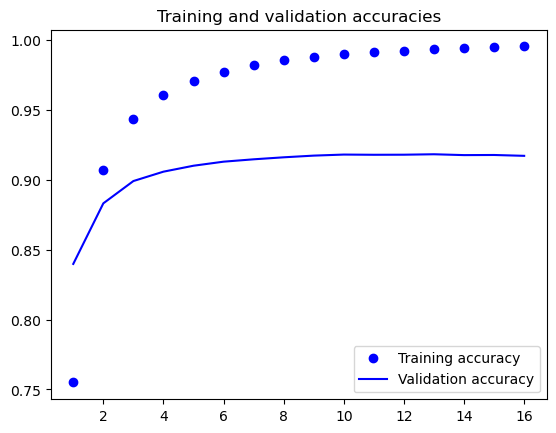

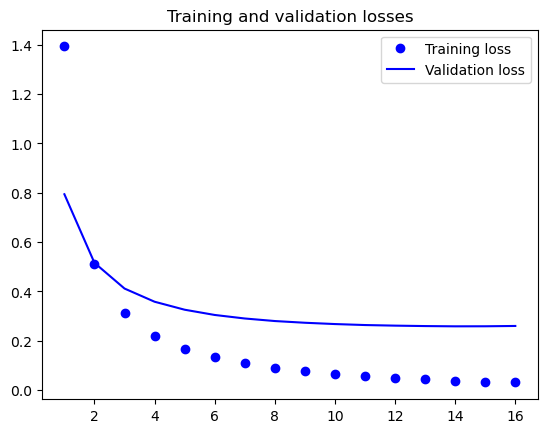

In [42]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

In [43]:
model.eval()

Sequential(
  (0): Linear(in_features=81629, out_features=18, bias=True)
)

In [44]:
X_test[:10]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [45]:
acc_loss, acc_test = evaluate(model, loss_fn, test_dataloader)
acc_loss, acc_test

(0.25462001676742846, 0.9209007574961736)

### Predict the sentences

In [46]:
def predict_sentence(sentence,
                     model,
                     idx2pos,
                     dict_vectorizer,
                     ppos_key='PPOS', lc=True):
    sent_words, _ = extract_cols(sentence)
    if lc:
        sent_words = list(map(str.lower, sent_words))
    X_cat = create_X_cat(sent_words)
    X = dict_vectorizer.transform(X_cat)
    y_pred_vec = torch.argmax(model(torch.from_numpy(X)),
                              dim=-1)
    # We add the predictions in the PPOS column
    for row, y_pred in zip(sentence, y_pred_vec):
        row[ppos_key] = idx2pos[y_pred.item()]
    return sentence

In [47]:
for sent in test_dict:
    predict_sentence(sent, model, idx2pos, dict_vectorizer, lc=LOWERCASE)

## Evaluate the prediction

In [48]:
test_dict[:2]

[[{'ID': '1',
   'FORM': 'What',
   'LEMMA': 'what',
   'UPOS': 'PRON',
   'XPOS': 'WP',
   'FEATS': 'PronType=Int',
   'HEAD': '0:root',
   'DEPREL': 'root',
   'DEPS': '_',
   'PPOS': 'PRON'},
  {'ID': '2',
   'FORM': 'if',
   'LEMMA': 'if',
   'UPOS': 'SCONJ',
   'XPOS': 'IN',
   'FEATS': '_',
   'HEAD': '4:mark',
   'DEPREL': 'mark',
   'DEPS': '_',
   'PPOS': 'SCONJ'},
  {'ID': '3',
   'FORM': 'Google',
   'LEMMA': 'Google',
   'UPOS': 'PROPN',
   'XPOS': 'NNP',
   'FEATS': 'Number=Sing',
   'HEAD': '4:nsubj',
   'DEPREL': 'nsubj',
   'DEPS': '_',
   'PPOS': 'PROPN'},
  {'ID': '4',
   'FORM': 'Morphed',
   'LEMMA': 'morph',
   'UPOS': 'VERB',
   'XPOS': 'VBD',
   'FEATS': 'Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin',
   'HEAD': '1:advcl:if',
   'DEPREL': 'advcl',
   'DEPS': '_',
   'PPOS': 'NOUN'},
  {'ID': '5',
   'FORM': 'Into',
   'LEMMA': 'into',
   'UPOS': 'ADP',
   'XPOS': 'IN',
   'FEATS': '_',
   'HEAD': '6:case',
   'DEPREL': 'case',
   'DEPS': '_',
   'PPOS': 

In [49]:
(y_true, y_pred) = ([], [])
for sent in test_dict:
    a, b = extract_cols(sent, x='UPOS', y='PPOS')
    y_true += a
    y_pred += b

In [50]:
target_names = sorted(pos2idx.keys(), key=lambda x: pos2idx[x])
target_names

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X',
 '_']

In [51]:
print(classification_report(y_true, y_pred, digits=4, target_names=target_names))

              precision    recall  f1-score   support

         ADJ     0.8831    0.8747    0.8789      1788
         ADP     0.9379    0.9503    0.9441      2034
         ADV     0.8856    0.8622    0.8738      1176
         AUX     0.9825    0.9819    0.9822      1543
       CCONJ     0.9932    0.9891    0.9912       737
         DET     0.9873    0.9842    0.9857      1897
        INTJ     0.9802    0.8250    0.8959       120
        NOUN     0.8384    0.9202    0.8774      4137
         NUM     0.9095    0.7601    0.8281       542
        PART     0.9652    0.9831    0.9740       649
        PRON     0.9757    0.9847    0.9802      2162
       PROPN     0.8227    0.7106    0.7626      2077
       PUNCT     0.9900    0.9877    0.9888      3096
       SCONJ     0.8442    0.7760    0.8087       384
         SYM     0.8511    0.7339    0.7882       109
        VERB     0.9151    0.9424    0.9285      2606
           X     0.2500    0.0256    0.0465        39
           _     1.0000    

## Applying the model to sentences

A few sentences:

In [52]:
sentences = ['That round table might collapse .',
             'That man can learn well .',
             'This man can swim well .',
             'The man can simwo .',
             'That round table might collapsex .']

We convert them into CoNLL-like tables

In [53]:
def sentence_to_conll(sentence: str):
    sent_dict = [{'ID': x, 'FORM': y} for (x, y) in
                 enumerate(sentence.split(), start=1)]
    return sent_dict

And we tag them

In [54]:
for sentence in sentences:
    sentence = sentence_to_conll(sentence)
    y_test_pred_cat = predict_sentence(sentence,
                                       model,
                                       idx2pos,
                                       dict_vectorizer,
                                       lc=LOWERCASE)
    print([y['FORM'] for y in y_test_pred_cat])
    print([y['PPOS'] for y in y_test_pred_cat])

['That', 'round', 'table', 'might', 'collapse', '.']
['DET', 'ADJ', 'NOUN', 'AUX', 'VERB', 'PUNCT']
['That', 'man', 'can', 'learn', 'well', '.']
['DET', 'NOUN', 'AUX', 'VERB', 'INTJ', 'PUNCT']
['This', 'man', 'can', 'swim', 'well', '.']
['DET', 'NOUN', 'AUX', 'VERB', 'INTJ', 'PUNCT']
['The', 'man', 'can', 'simwo', '.']
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
['That', 'round', 'table', 'might', 'collapsex', '.']
['DET', 'ADJ', 'NOUN', 'AUX', 'VERB', 'PUNCT']


In [55]:
torch.save(model.state_dict(), 'pos_pytorch')

: 